# This script is used to explore flow events.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Define dir and site
site = '212058'
fig_dir = f'../output/figs/{site}/'
date_postfire = pd.to_datetime('2020-01-17')
date_postyear = pd.to_datetime('2021-06-30')
freq = 'Hourly'

## 1 Data processing and formating

In [55]:
# Process data to format that R package requires for storm event separation.
fn = f'../data/{site}_{freq}.csv'
output_fn = f'../output/{site}_{freq}.csv'
# Read the formated file if it exists.
if os.path.exists(output_fn):
    cq_data = pd.read_csv(output_fn, index_col = 'id')
else: #Generate the formated file if it does not exist.
    cols = ['Discharge (ML/d)', 'Turbidity (NTU)'] # site 212058 does not have rainfall data from the web. 'Rainfall (mm)', 
    cq_data = pd.read_csv(fn, index_col = 'Date and time', skiprows = 3, usecols = [0, 1, 3])
    cq_data.rename(columns={cq_data.columns[ii]: cols[ii] for ii in range(len(cols))}, inplace = True)
    cq_data.index.name = 'Datetime'
    # Process data
    # Drop rows if Turbidity is of value NaN
    cq_data.dropna(axis = 0, how = 'all', inplace = True)
    cq_data.index = pd.to_datetime(cq_data.index, dayfirst = True, format = "%H:%M:%S %d/%m/%Y" )
    cq_data.reset_index(inplace=True)
    cq_data['Discharge (cms)'] = round(cq_data['Discharge (ML/d)'] * 1e3 / 86400, 3)
    cq_data.to_csv(f'../output/{site}_{freq}.csv', index_label='id')

## 2. Plots show start of postfire for each catchment.

### 2.1 Plot for 212058

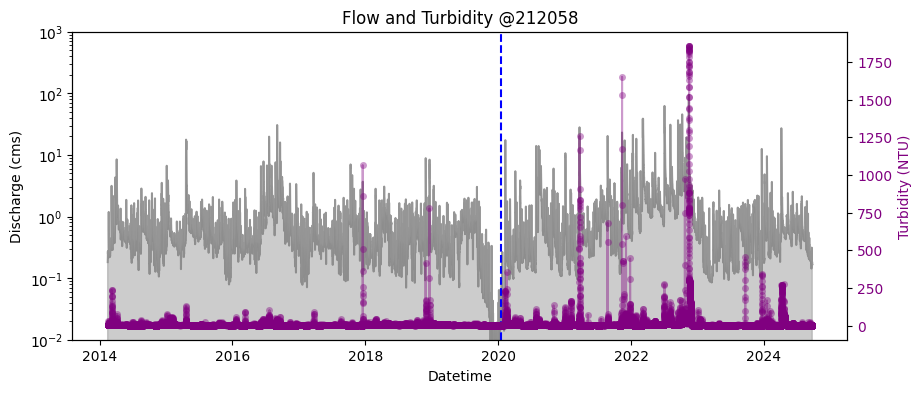

In [56]:
# Set up the figure and axes
plt.figure(figsize=(10, 4))
# convert Datatime column to datetime format
cq_data['Datetime'] = pd.to_datetime(cq_data['Datetime'], format="mixed", dayfirst=True)
# cq_plot = cq_data[(cq_data['Datetime'] < '2020-5-30') & (cq_data['Datetime'] > '2019-8-01')]
cq_plot = cq_data
cols = cq_plot.columns
# Adding a title
plt.title(f'Flow and Turbidity @{site}')
# Plot discharge using Seaborn
ax = sns.lineplot(x=cols[0], y=cols[-1], data=cq_plot, color='grey', alpha=0.7)
# Fill the area below the line
ax.fill_between(cq_plot[cols[0]], cq_plot[cols[-1]], color='grey',  alpha=0.4)
ax.set_ylabel(cols[-1], color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.set_yscale('log')
ax.set_ylim(0.01, 1e3)
# Create a second y-axis for rainfall
ax2 = ax.twinx()

# Plot Turbidity using Seaborn
sns.lineplot(x=cols[0], y=cols[2], data=cq_plot, ax=ax2, color='purple', marker='o', \
            markeredgecolor='none', alpha = 0.4, markersize = 5)
ax2.set_ylabel(cols[2], color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
# ax2.set_yscale('log')
# Add a horizontal line at a specific y-value (for example, y = 5)
ax.axvline(x=pd.to_datetime('2020-01-17'), color='blue', linestyle='--', label='Threshold Line')

# Show the plot
# plt.savefig(f'../output/figs/{site}/{site}_{freq}_CQ_whole_timeseries.png', bbox_inches = 'tight', dpi=300, format = 'png')

## 2.2 Plot event duration and peak flow distribution.

In [59]:
# Read the StormEventSummaryData
storm_summary = pd.read_csv('../output/CQ_analysis/212058/' + \
                            'QAbove_2_212058_StormEventClean.csv', index_col = 'id')

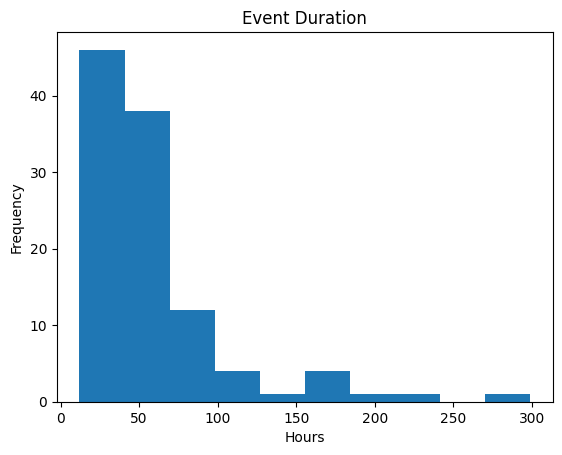

In [61]:
# Hist plot of Event Duration (Hours)
storm_summary.duration_hrs.plot(kind='hist')
plt.xlabel('Hours')
plt.title('Event Duration')
plt.savefig(f'{fig_dir}EventDurationHrs.png', format = 'png', dpi=300)

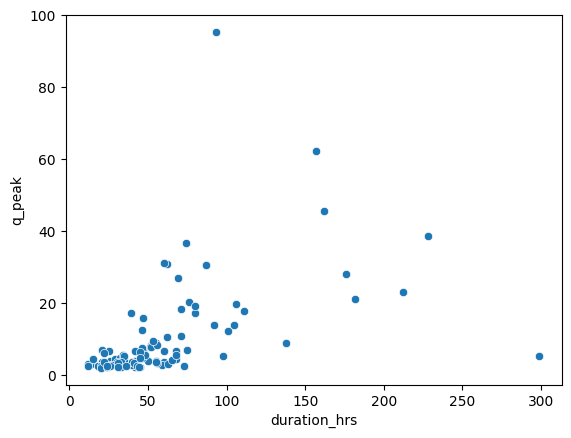

In [63]:
# Scatter plot of Event Duration and Peakflow
sns.scatterplot(data=storm_summary, x = 'duration_hrs', y = 'q_peak')
plt.savefig(f'{fig_dir}EventDurationVsPeakFLow.png', format = 'png', dpi=300)

## 3-1 Explore C-Q for pre and post fire periods

In [64]:
from functions import plot_storm_cq
#TODO: solve the issue with duplicate index!!!

In [65]:
# Read storm event data
freq = 'Hourly'
Q_thre = 2
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'Q_above_{Q_thre}_212058_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
site = 212058
x_lab = cols[3]
y_lab = cols[2]
storm_data.drop_duplicates('Datetime', inplace=True)

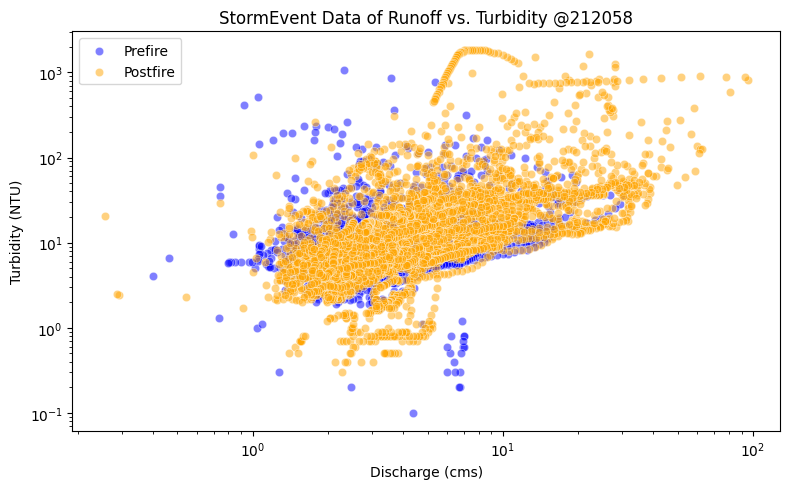

In [66]:
# Scatter plot
plot_storm_cq(storm_data, x_lab, y_lab, freq, site, date_postfire, Q_thre, colors = ['blue', 'orange'], marker='o', \
                  alpha = 0.5, labels = ['Prefire', 'Postfire'])

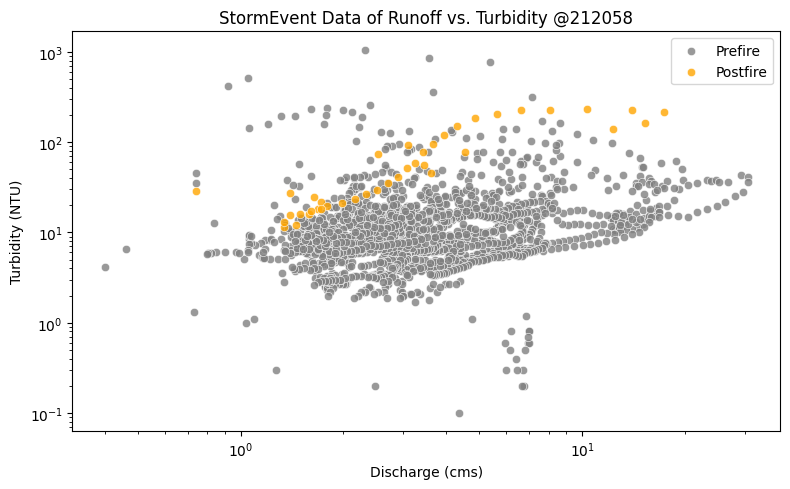

In [70]:
# Scatter plot with colors distinguished between events.
# Scatter plot using HOURLY data
# Read storm event data
Q_thre = 2
storm_data_post = pd.read_csv(f'../output/CQ_analysis/{site}/' + f'Q_above_{Q_thre}_{site}_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data_post.columns
storm_data_post['Datetime'] = pd.to_datetime(storm_data_post['Datetime'])
df_temp = storm_data_post[(storm_data_post['Datetime'] >= date_postfire) & (storm_data_post['stormID'] == 38)]
data_comb = pd.concat([storm_data[storm_data['Datetime'] < date_postfire], df_temp])

# Scatter plot
plot_storm_cq(data_comb, x_lab, y_lab, freq, site, date_postfire, 'comb', colors = ['grey', 'orange'], marker='o', \
                  alpha = 0.8, labels = ['Prefire', 'Postfire'])

## 3-2 Plot hysteresis index 

In [ ]:
# import data
hys_fn = '212058_NTU_HysteresisData.csv'
hys_df = pd.read_csv(f'../output/CQ_analysis/{site}/' + hys_fn, index_col='id')
hys_df['start'] = pd.to_datetime(hys_df['start'], format='mixed', dayfirst=True)
hys_df['intensity_m3_s'] = hys_df['intensity_m3_hr']/3600
pre_hys = hys_df[hys_df['start'] < date_postfire].dropna()
post_hys = hys_df[(hys_df['start'] >= date_postfire) & (hys_df['start'] <= date_postyear)].dropna()

KeyError: 'start'

### 3-3 Histplot of Flush Index for pre and post fire

<Axes: xlabel='flsh_index', ylabel='hyst_index'>

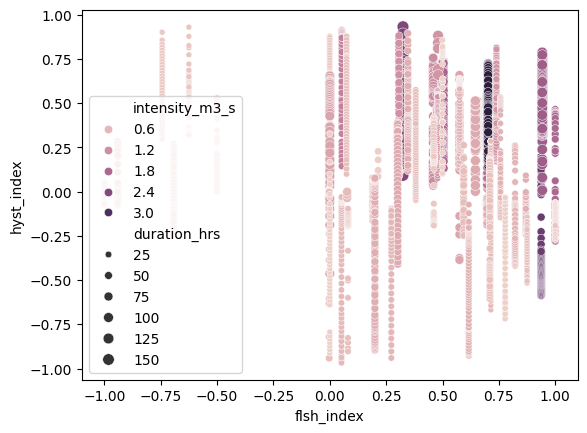

In [24]:
sns.scatterplot(data=post_hys, x='flsh_index', y='hyst_index', size='duration_hrs', \
                hue='intensity_m3_s')

<Axes: xlabel='flsh_index', ylabel='hyst_index'>

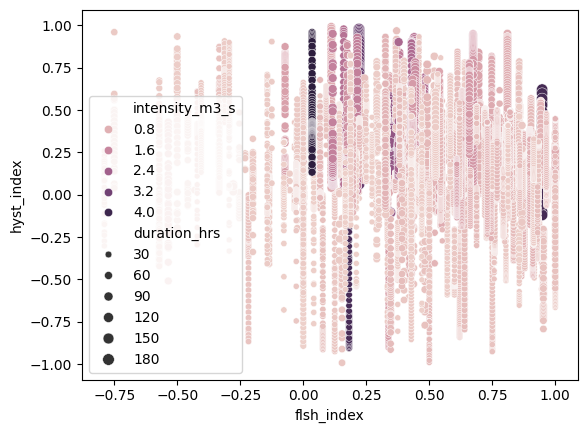

In [ ]:
sns.scatterplot(data=pre_hys, x='flsh_index', y='hyst_index')

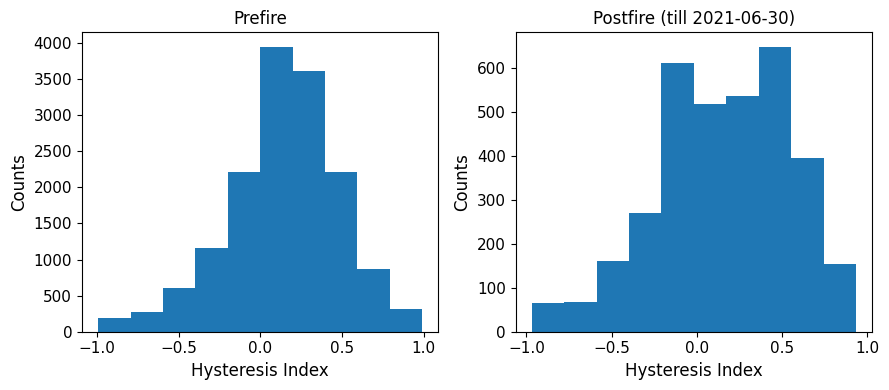

In [44]:
# Plot hysteresis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
title_labels = ['Prefire', f'Postfire (till {date_postyear.date()})']
kk = 0
for df_temp in [pre_hys, post_hys]:
    axes[kk].hist(df_temp['hyst_index'].unique())
    axes[kk].set_ylabel('Counts', fontsize = 12)
    axes[kk].set_xlabel('Hysteresis Index', fontsize = 12)
    axes[kk].tick_params(axis='both', which = 'major', labelsize = 11)
    axes[kk].set_title(title_labels[kk], loc='center', fontsize = 12)
    kk += 1
plt.tight_layout()
plt.savefig(f'{fig_dir}HystIndexHist.png', format = 'png', dpi=300)

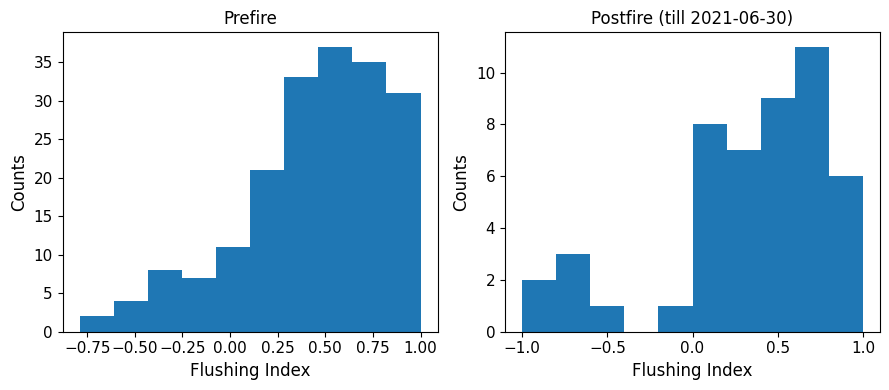

In [43]:
# Plot flushing index
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
title_labels = ['Prefire', f'Postfire (till {date_postyear.date()})']
kk = 0
for df_temp in [pre_hys, post_hys]:
    axes[kk].hist(df_temp['flsh_index'].unique())
    axes[kk].set_ylabel('Counts', fontsize = 12)
    axes[kk].set_xlabel('Flushing Index', fontsize = 12)
    axes[kk].tick_params(axis='both', which = 'major', labelsize = 11)
    axes[kk].set_title(title_labels[kk], loc='center', fontsize = 12)
    kk += 1
plt.tight_layout()
plt.savefig(f'{fig_dir}FlushIndexHist.png', format = 'png', dpi=300)

### Plot hysteresis for 10 events before and after bushfire

array(['storm_242', 'storm_243', 'storm_244', 'storm_245', 'storm_246',
       'storm_247', 'storm_248', 'storm_249', 'storm_250', 'storm_251',
       'storm_252', 'storm_253', 'storm_254', 'storm_255', 'storm_256',
       'storm_257', 'storm_258', 'storm_259', 'storm_260', 'storm_261',
       'storm_262', 'storm_263', 'storm_264', 'storm_265', 'storm_266',
       'storm_267', 'storm_268', 'storm_269', 'storm_270', 'storm_271',
       'storm_272', 'storm_273', 'storm_274', 'storm_275', 'storm_276',
       'storm_277', 'storm_278', 'storm_279', 'storm_280', 'storm_281',
       'storm_282', 'storm_283', 'storm_284', 'storm_285', 'storm_286',
       'storm_287', 'storm_288', 'storm_289', 'storm_290', 'storm_291',
       'storm_292'], dtype=object)

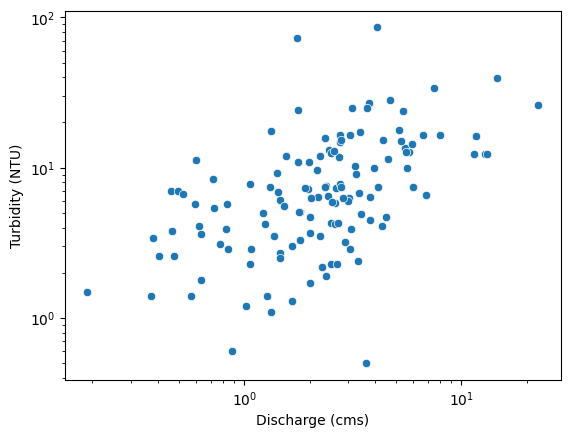

In [ ]:
## Explore the relationship in 1/n space
# Read storm event data
freq = 'Hourly'
Q_thre = 2
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'DailyQ_above_{Q_thre}_212058_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
site = 212058
x_lab = cols[3]
y_lab = cols[2]
storm_data.drop_duplicates('Datetime', inplace=True)
# Scatter plot
sns.scatterplot(x=x_lab, y=y_lab, data=storm_data[storm_data.Datetime < date_postfire])
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='Discharge (cms)', ylabel='Turbidity (NTU)'>

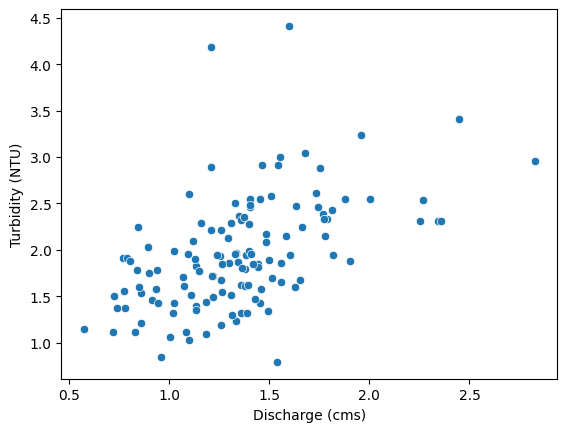

In [30]:
## Explore the relationship in 1/n space
# Read storm event data
freq = 'Hourly'
Q_thre = 2
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'DailyQ_above_{Q_thre}_212058_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
site = 212058
x_lab = cols[3]
y_lab = cols[2]
n = 3
storm_data.loc[:, x_lab] = np.power(storm_data.loc[:, x_lab], 1/n)
storm_data.loc[:, y_lab] = np.power(storm_data.loc[:, y_lab], 1/n)
storm_data.drop_duplicates('Datetime', inplace=True)
# Scatter plot
sns.scatterplot(x=x_lab, y=y_lab, data=storm_data[storm_data.Datetime < date_postfire])